In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")

In [2]:
df = pd.read_csv("run-1651496245771-part-r-00000")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  60 non-null     object 
 1   close     60 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [4]:
df.head()

,datetime,close
0,2022-04-25 14:30:00,990.56500
1,2022-04-25 15:30:00,998.28998
2,2022-04-26 09:30:00,921.92999
3,2022-04-26 10:30:00,907.50000
4,2022-04-26 11:30:00,905.00000


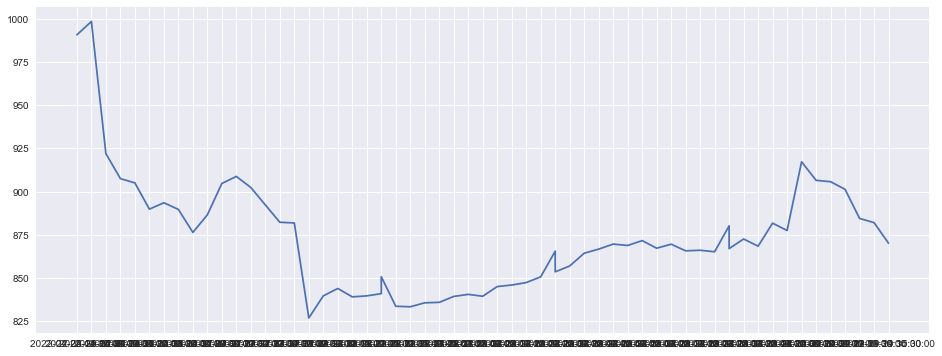

In [5]:
df.set_index("datetime", drop=True, inplace=True)
df = df[["close"]]
plt.figure(1, figsize=(16, 6))
_ = plt.plot(df.close)

Calculate the percentage change.

The reason for using pct_change instead of the prices is the benefit of normalization as we can measure all variables in a comparable metric. Also returns have more manageable statistical properties than prices such as stationarity, as in most cases we don't have stationary prices but we can have stationary returns.

A stationary time series is one where statistical properties such as mean, variance, correlation, etc are constant over time.
For more details on stationarity: https://en.wikipedia.org/wiki/Stationary_process

In [6]:
df["returns"] = df.close.pct_change()

Calculate the log returns.

Why use log returns: https://quantivity.wordpress.com/2011/02/21/why-log-returns/

In [7]:
df["log_returns"] = np.log(1 + df["returns"])

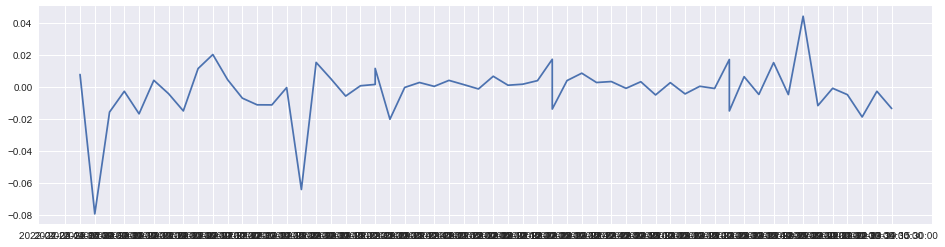

In [8]:
plt.figure(1, figsize=(16, 4))
plt.plot(df.log_returns)

In [9]:
df.dropna(inplace=True)
X = df[["close", "log_returns"]].values

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)
y = [x[0] for x in X_scaled]

We want to predict the stock price at a future time. We'll predict the stock price at time t + 1 relative to the stock price at time t.

As we're going to use an LSTM architecture, we know that it has memory and that it is maintained by setting the time step, basically how many steps in the past we want the LSTM to use.

The time step  refers to how many steps in time we want the backpropagation algorithm to use when calculating gradients for weight updates during training.

So we can use a method to create both the timestep and the output variable, the t + 1.

In [11]:
n = 3
Xtest = []
ytest = []
for i in range(n, len(X_scaled)):
    Xtest.append(X_scaled[i - n : i, : X_scaled.shape[1]])
    ytest.append(y[i])  # predict next record

In [12]:
Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [13]:
print(Xtest.shape)
print(ytest.shape)

(56, 3, 2)
(56,)


In [14]:
from keras.models import load_model

In [15]:
model = load_model('model.h5')

In [17]:
pricePrediction = model.predict(Xtest)

# Convertir a precio legible
pricePrediction = np.c_[pricePrediction, np.zeros(pricePrediction.shape)]
pricePrediction = scaler.inverse_transform(pricePrediction)
pricePrediction = [x[0] for x in pricePrediction]

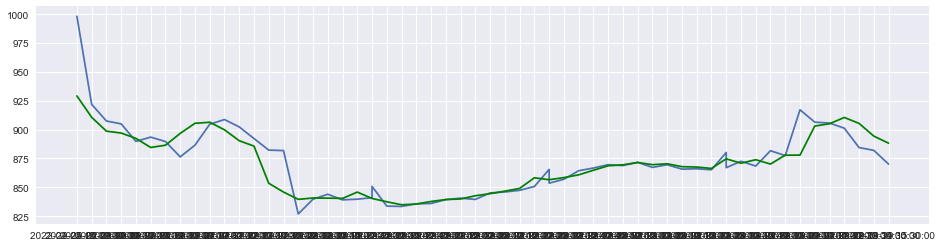

In [36]:
plt.figure(1, figsize=(16, 4))
plt.plot(df.close)
plt.plot(pricePrediction, color='green')